#### IMPORT LIBRARIES

In [1]:
import numpy as np
import h5py as h5

import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
from importlib import reload, import_module

import glob
import os

import pdb
from PIL import Image as im
import _pickle as pickle
import cv2

from functions import processLF, get_variable, get_numpy, psnr_1

#### DATASET PATH

In [2]:
if os.name == 'nt':
    dataset_file = r"C:\Users\mummu\Documents\Datasets\srinivasan\trainset\h5\8bit.h5"
    test_file    = r"C:\Users\mummu\Documents\Datasets\srinivasan\testset\h5\8bit.h5"
    model_file   = r"model\model.pt"
    network_file = r"network"
    img_dir      = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\EXTRA"
    img_paper    = r"C:\Users\mummu\Documents\Datasets\kalantari\testset\PAPER"
    
elif os.name == 'posix':
    raise NotImplementedError

#### BASIC PARAMETERS

In [3]:
minibatch_size = 1
gamma_val      = 0.4
lfsize         = [372, 540, 7, 7]
batch_affine   = True

In [4]:
trans = transforms.ToTensor()
p = np.ndarray([1])
q = np.ndarray([1])

In [5]:
network_module = import_module(network_file)
reload(network_module)

Net = network_module.Net

net = Net((lfsize[0], lfsize[1]), minibatch_size, lfsize, batchAffine=batch_affine)
net.eval()

if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

try:
    checkpoint = torch.load(model_file)
    
    net.load_my_state_dict(checkpoint['model'].state_dict())    
    print('Model successfully loaded.')
    
except:
    print('No model.')

##converting network to cuda-enabled
Model successfully loaded.


In [6]:
# To delete
#result = im.fromarray((get_numpy(corn[0,:3].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner1_f.png');
#result = im.fromarray((get_numpy(corn[0,3:6].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner2_f.png');
#result = im.fromarray((get_numpy(corn[0,6:9].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner3_f.png');
#result = im.fromarray((get_numpy(corn[0,9:].permute(1,2,0)+1)/2 * 255).astype(np.uint8));result.save('corner4_f.png');

In [7]:
def single_run(index, img_path = img_paper, img_name = 'Seahorse.png'):
            
    img = cv2.imread(os.path.join(img_path, img_name))
                    
    img = processLF(trans(img), lfsize, gamma_val)
    
    T = img[:, :, index[0], index[1], :].squeeze()
    corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()
    
    Y, R = synthesizeView(corn, index)

    return T, Y, R

In [8]:
def synthesizeView(corn, index):
                
    p[0] = (index[0] - lfsize[2]//2)/(lfsize[2]//2)
    q[0] = (index[1] - lfsize[3]//2)/(lfsize[3]//2)
    
    corn = corn.permute(2,3,0,1).reshape(12,corn.shape[0],corn.shape[1])[None,:]

    with torch.no_grad():
        Y, R = net(get_variable(corn), get_variable(torch.from_numpy(p)), get_variable(torch.from_numpy(q)))
        
    return Y[0].permute(1,2,0), R[0].permute(1,2,0)

In [11]:
T, Y, R = single_run([3,3], img_name = 'Rock.png')

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 5.0000e+00,
        1.0000e+00, 2.0000e+00, 2.0000e+00, 5.0000e+00, 5.0000e+00,
        6.0000e+00, 5.0000e+00, 1.1000e+01, 3.0000e+00, 9.0000e+00,
        1.0000e+01, 5.0000e+00, 8.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 1.1000e+01, 1.9000e+01, 1.4000e+01,
        2.6000e+01, 3.1000e+01, 3.1000e+01, 3.1000e+01, 3.0000e+01,
        3.9000e+01, 4.7000e+01, 6.3000e+01, 6.7000e+01, 6.9000e+01,
        7.5000e+01, 9.6000e+01, 1.0700e+02, 9.8000e+01, 1.1700e+02,
        1.5400e+02, 1.5300e+02, 1.9000e+02, 2.0000e+02, 3.0600e+02,
        3.6400e+02, 4.1300e+02, 5.0500e+02, 6.04

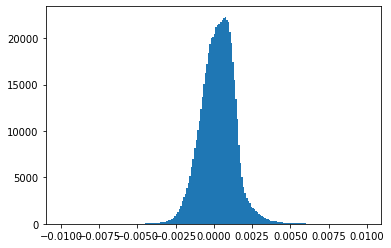

In [28]:
plt.hist((get_numpy(R.reshape(-1,1))),bins=np.arange(-0.01, 0.01, 0.0001))

In [ ]:
# Run for all examples in the folder and every perspectives
def run_all_examples(img_path):
        
    files = [file for file in os.listdir(img_path) if file.endswith(".png")]
    ps = np.ndarray((len(files),7,7))

    for fi in range(len(files)):

        file = files[fi]

        print("Current file {}: {}" .format(fi,file))

        img = cv2.imread(os.path.join(img_path, file))
        img = processLF(trans(img), lfsize, gamma_val)

        corn = img[:, :, [0, -1, 0, -1], [0, 0, -1, -1], :].squeeze()

        for i in range(7):
            for j in range(7):

                T = get_numpy(img[:, :, i, j, :])
                Y,R,d = synthesizeView(corn, [i, j])
                Y = get_numpy(Y)

                ps[fi,i,j] = psnr_1(T, Y)
        
        psnr_excl_corners = ps[fi].reshape(-1)[[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()
        
        print("Current PSNR: {}" .format(psnr_excl_corners))
    
    return ps
                
    

In [ ]:
ps = run_all_examples(img_paper)

In [ ]:
np.set_printoptions(precision = 2)
ps[3]

In [ ]:
# np.set_printoptions(precision=2)
# print(ps)

#for index, val in enumerate(list)
files = [file for file in os.listdir(img_dir) if file.endswith(".png")]

In [ ]:
#for _, fi in enumerate(files):
ps.reshape(len(files),-1)[:,[i for i in range(49) if (i-np.array((0,6,42,48))).all()]].mean()